In [1]:
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import re
from numpyro.infer.initialization import init_to_value
from jax.nn import softmax
from sklearn.preprocessing import LabelBinarizer
from jax import ops
from jax.experimental import loops
import jax

numpyro.util.set_rng_seed(0)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [2]:
# Create folder for storing results

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
new_dir = os.path.join("../../output/multi_class/", "numpyro_nc_" + time)
os.mkdir(new_dir)

In [3]:
print(new_dir)

../../output/multi_class/numpyro_nc_2021_05_13_13_01_48


In [4]:
ITER = 100000
CHAINS = 4

In [5]:
def load_data():

    # Load Data

    df = pd.read_table("../../data/cdata", header=None, delim_whitespace=True)
    df.columns = ["X1", "X2", "X3", "X4", "Y"]
    df["index"] = np.where(df.index < 400, "Train", "Test")

    # Create train and test

    X_train = np.array(df.loc[df["index"] == "Train", ["X1", "X2", "X3", "X4"]]).reshape(-1, 4)
    Y_train = np.array(df.loc[df["index"] == "Train", "Y"])
    X_test = np.array(df.loc[df["index"] == "Test", ["X1", "X2", "X3", "X4"]]).reshape(-1, 4)
    Y_test = np.array(df.loc[df["index"] == "Test", "Y"])

    return X_train, X_test, Y_train, Y_test

In [6]:
X_train, X_test, Y_train, Y_test = load_data()

In [7]:
# One hot encode Y_train to align with dist.Multinomial()

Y_train_ohe = LabelBinarizer().fit_transform(Y_train)

In [8]:
def model(x, y):
        
    # Hyperparameters (that do not need to be centered)
    
    w_ih_prec = numpyro.sample("w_ih_prec", dist.Gamma(0.25, 0.000625))
    b_h_prec = numpyro.sample("b_h_prec", dist.Gamma(0.25, 0.000625))
    w_ho_prec = numpyro.sample("w_ho_prec", dist.Gamma(0.25, 7.8125e-05))
    b_o_prec = numpyro.sample("b_o_prec", dist.Gamma(0.25, 0.000625))
    
    # ARD Hyperparameters for inputs 
    
    w_ih_prec_1_raw = numpyro.sample("w_ih_prec_1", dist.Gamma(0.5, 1))
    w_ih_prec_2_raw = numpyro.sample("w_ih_prec_2", dist.Gamma(0.5, 1))
    w_ih_prec_3_raw = numpyro.sample("w_ih_prec_3", dist.Gamma(0.5, 1))
    w_ih_prec_4_raw = numpyro.sample("w_ih_prec_4", dist.Gamma(0.5, 1))
    
    # Remove scaling
    
    w_ih_prec_1 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_1_raw
    w_ih_prec_2 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_2_raw
    w_ih_prec_3 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_3_raw
    w_ih_prec_4 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_4_raw
    
    # Raw low level parameters
    
    w_ih_1_raw = numpyro.sample("w_ih_1", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    w_ih_2_raw = numpyro.sample("w_ih_2", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    w_ih_3_raw = numpyro.sample("w_ih_3", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    w_ih_4_raw = numpyro.sample("w_ih_4", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    
    # Low Level Parameters

    b_h_raw = numpyro.sample("b_h", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    w_ho_raw = numpyro.sample("w_ho", dist.Normal(loc=jnp.zeros((8, 3)), scale=1))
    b_o_raw = numpyro.sample("b_o", dist.Normal(loc=jnp.zeros((1, 3)), scale=1))
    
    # Non-centered parametrization
    
    # Low-Level parameters
    
    w_ih_1 = (1/jnp.sqrt(w_ih_prec_1)) * w_ih_1_raw
    w_ih_2 = (1/jnp.sqrt(w_ih_prec_2)) * w_ih_2_raw
    w_ih_3 = (1/jnp.sqrt(w_ih_prec_3)) * w_ih_3_raw
    w_ih_4 = (1/jnp.sqrt(w_ih_prec_4)) * w_ih_4_raw
    
    b_h = (1/jnp.sqrt(b_h_prec)) * b_h_raw
    w_ho = (1/jnp.sqrt(w_ho_prec)) * w_ho_raw
    b_o = (1/jnp.sqrt(b_o_prec)) * b_o_raw
    
    # Forward Pass
    
    w_ih = jnp.stack([w_ih_1, w_ih_2, w_ih_3, w_ih_4], axis=1).reshape(4, 8)
    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    output_sm = softmax(output)
    
    return numpyro.sample("y_pred", dist.Multinomial(total_count=1, probs=output_sm), obs=y)

In [9]:
init_values = {
    
    "w_ih_prec": 1.,
    "w_ih_prec_1": 1.,
    "w_ih_prec_2": 1.,
    "w_ih_prec_3": 1.,
    "w_ih_prec_4": 1.,
    "b_h_prec": 1.,
    "w_ho_prec": 1.,
    "w_ih_1": jnp.zeros((1, 8)),
    "w_ih_2": jnp.zeros((1, 8)),
    "w_ih_3": jnp.zeros((1, 8)),
    "w_ih_4": jnp.zeros((1, 8)),
    "b_h": jnp.zeros((1, 8)),
    "w_ho": jnp.zeros((8, 3)),
    "b_o": jnp.zeros((1, 3))

}

In [10]:
rng_key = random.PRNGKey(42)
rng_key, rng_key_predict = random.split(rng_key)

nuts_kernel = NUTS(model, adapt_mass_matrix=True, 
                   init_strategy = init_to_value(values=init_values))

mcmc = MCMC(nuts_kernel,
            num_samples=ITER,
            num_warmup=1000,
            num_chains=CHAINS,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)

mcmc.run(rng_key,
         jnp.array(X_train.reshape((len(Y_train), 4))), 
         jnp.array(Y_train_ohe.reshape((len(Y_train), 3))))

mcmc.print_summary()

samples = mcmc.get_samples()






                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_h[0,0]     -0.03      1.01     -0.04     -1.66      1.64   7642.56      1.00
     b_h[0,1]      0.05      1.03      0.09     -1.66      1.65    725.62      1.01
     b_h[0,2]     -0.01      1.01      0.01     -1.65      1.65  24217.84      1.00
     b_h[0,3]      0.03      1.08      0.02     -1.56      1.84    244.82      1.02
     b_h[0,4]     -0.04      1.06     -0.02     -1.85      1.51    313.64      1.01
     b_h[0,5]     -0.00      1.01      0.01     -1.64      1.67  25722.44      1.00
     b_h[0,6]     -0.01      1.00     -0.06     -1.67      1.64  54489.91      1.00
     b_h[0,7]      0.03      1.02     -0.02     -1.64      1.67   1473.36      1.00
     b_h_prec      3.54     57.74      0.25      0.00      1.26  74500.84      1.00
     b_o[0,0]     -0.11      0.97     -0.16     -1.70      1.52   8929.92      1.00
     b_o[0,1]     -0.06      0.98     -0.03     -1.59      1.59    487.

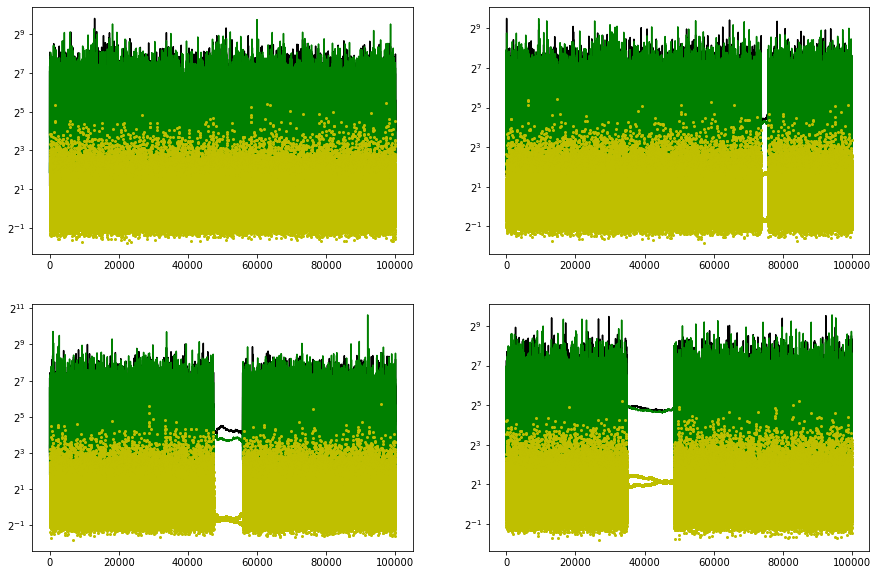

In [11]:
plt.figure(figsize = (15,10))
BASE = 2

plt.subplot(2, 2, 1)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][1:(ITER)]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][1:(ITER)]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][1:(ITER)]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][1:(ITER)]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][ITER:2*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][ITER:2*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][ITER:2*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][ITER:2*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 3)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][2*ITER:3*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][2*ITER:3*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][2*ITER:3*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][2*ITER:3*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 4)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][3*ITER:4*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][3*ITER:4*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][3*ITER:4*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][3*ITER:4*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

In [12]:
def prob_prediction(x, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o):
    
    w_ih = jnp.stack([w_ih_1, w_ih_2, w_ih_3, w_ih_4], axis=1).reshape(4, 8)
    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    
    return softmax(output)

In [13]:
def parse_samples(samples, i):
    
    # Extract samples

    w_ih_1_raw = samples["w_ih_1"][i]
    w_ih_2_raw = samples["w_ih_2"][i]
    w_ih_3_raw = samples["w_ih_3"][i]
    w_ih_4_raw = samples["w_ih_4"][i]
    b_h_raw = samples["b_h"][i]
    w_ho_raw = samples["w_ho"][i]
    b_o_raw = samples["b_o"][i]
    
    # Extract hyperparameters
    
    w_ih_prec = samples["w_ih_prec"][i]

    # X1

    w_ih_prec_1_raw = samples["w_ih_prec_1"][i]
    w_ih_prec_1 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_1_raw
    # w_ih_prec_1 = w_ih_prec_1_raw
    w_ih_1 = (1/jnp.sqrt(w_ih_prec_1)) * w_ih_1_raw

    # X2

    w_ih_prec_2_raw = samples["w_ih_prec_2"][i]
    w_ih_prec_2 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_2_raw
    # w_ih_prec_2 = w_ih_prec_2_raw
    w_ih_2 = (1/jnp.sqrt(w_ih_prec_2)) * w_ih_2_raw

    # X3

    w_ih_prec_3_raw = samples["w_ih_prec_3"][i]
    w_ih_prec_3 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_3_raw
    # w_ih_prec_3 = w_ih_prec_3_raw
    w_ih_3 = (1/jnp.sqrt(w_ih_prec_3)) * w_ih_3_raw

    # X4

    w_ih_prec_4_raw = samples["w_ih_prec_4"][i]
    w_ih_prec_4 = 1/(0.5*(1/w_ih_prec))*w_ih_prec_4_raw
    # w_ih_prec_4 = w_ih_prec_4_raw
    w_ih_4 = (1/jnp.sqrt(w_ih_prec_4)) * w_ih_4_raw
    
    # Parse others
    
    b_h_prec = samples["b_h_prec"][i]
    w_ho_prec = samples["w_ho_prec"][i]
    b_o_prec = samples["b_o_prec"][i]
    
    b_h = (1/jnp.sqrt(b_h_prec)) * b_h_raw
    w_ho = (1/jnp.sqrt(w_ho_prec)) * w_ho_raw
    b_o = (1/jnp.sqrt(b_o_prec)) * b_o_raw
    
    return w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o

In [14]:
with loops.Scope() as s:

    s.train_predictions = np.zeros((ITER * CHAINS, X_train.shape[0], 3))
    s.test_predictions = np.zeros((ITER * CHAINS, X_test.shape[0], 3))
    
    for i in s.range(0, len(samples["w_ih_1"])):

        w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o = parse_samples(samples, i)

        s.train_predictions = ops.index_update(s.train_predictions, jax.ops.index[i, :] ,
                                               prob_prediction(X_train, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o).reshape(
                                                   X_train.shape[0], 3))
        
        s.test_predictions = ops.index_update(s.test_predictions, jax.ops.index[i, :] ,
                                               prob_prediction(X_test, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o).reshape(
                                                   X_test.shape[0], 3))

In [15]:
# train_predictions = np.zeros((ITER * CHAINS, X_train.shape[0], 3))

# for i in range(0, len(samples["w_ih_1"])):
    
#     w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o = parse_samples(samples, i)
    
#     train_predictions[i, :] = prob_prediction(X_train, w_ih_1, w_ih_2, w_ih_3, w_ih_4,  
#                                               b_h, w_ho, b_o).reshape(X_train.shape[0], 3)

In [16]:
# test_predictions = np.zeros((ITER * CHAINS, X_test.shape[0], 3))

# for i in range(0, len(samples["w_ih_1"])):
    
#     w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o = parse_samples(samples, i)
    
#     test_predictions[i, :] = prob_prediction(X_test, w_ih_1, w_ih_2, w_ih_3, w_ih_4, 
#                                              b_h, w_ho, b_o).reshape(X_test.shape[0], 3)

In [17]:
# Re-assign probability predictions

y_train_pred = s.train_predictions
y_test_pred = s.test_predictions
train_mean_probs = y_train_pred.mean(axis=0)
test_mean_probs = y_test_pred.mean(axis=0)

In [18]:
# Train and Test Predictions

df_predictions_train = pd.DataFrame({
    
    "X_V1": X_train[:, 0].flatten(),
    "X_V2": X_train[:, 1].flatten(),
    "X_V3": X_train[:, 2].flatten(),
    "X_V4": X_train[:, 3].flatten(),
    "targets": Y_train.flatten(),
    "predicted": np.argmax(train_mean_probs, axis=1),
    "mean_prob_1": train_mean_probs[:, 0].flatten(),
    "mean_prob_2": train_mean_probs[:, 1].flatten(),
    "mean_prob_3": train_mean_probs[:, 2].flatten(),
    "label": "train"
})

df_predictions_test = pd.DataFrame({
    
    "X_V1": X_test[:, 0].flatten(),
    "X_V2": X_test[:, 1].flatten(),
    "X_V3": X_test[:, 2].flatten(),
    "X_V4": X_test[:, 3].flatten(),
    "targets": Y_test.flatten(),
    "predicted": np.argmax(test_mean_probs, axis=1),
    "mean_prob_1": test_mean_probs[:, 0].flatten(),
    "mean_prob_2": test_mean_probs[:, 1].flatten(),
    "mean_prob_3": test_mean_probs[:, 2].flatten(),
    "label": "test"

})

In [19]:
error = (df_predictions_test.targets - df_predictions_test.predicted).abs()
error[error > 1] = 1
error.sum()/len(error)*100

13.666666666666666

In [20]:
# TODO: get chains in order

In [21]:
# Low-level parameters

df_wih_1 = pd.DataFrame(samples['w_ih_1'].reshape(ITER*CHAINS, 8))
df_wih_2 = pd.DataFrame(samples['w_ih_2'].reshape(ITER*CHAINS, 8))
df_wih_3 = pd.DataFrame(samples['w_ih_3'].reshape(ITER*CHAINS, 8))
df_wih_4 = pd.DataFrame(samples['w_ih_4'].reshape(ITER*CHAINS, 8))
df_bh = pd.DataFrame(samples['b_h'].reshape(ITER*CHAINS, 8))
df_who = pd.DataFrame(samples['w_ho'].reshape(ITER*CHAINS, 24))
df_bo = pd.DataFrame(samples['b_o'].reshape(ITER*CHAINS, 3))

# Rename columns

df_wih_1.columns = ["w_ih_1_" + str(i) for i in range(0, 8)]
df_wih_2.columns = ["w_ih_2_" + str(i) for i in range(0, 8)]
df_wih_3.columns = ["w_ih_3_" + str(i) for i in range(0, 8)]
df_wih_4.columns = ["w_ih_4_" + str(i) for i in range(0, 8)]
df_bh.columns = ["b_h_" + str(i) for i in range(0, 8)]
df_who.columns = ["w_ho_" + str(i) for i in range(0, 24)]
df_bo.columns = ["b_o_" + str(i) for i in range(0, 3)]

df_traces = pd.concat([df_wih_1, df_wih_2, df_wih_3, df_wih_4, 
                       df_bh, df_who, df_bo], ignore_index=False, axis=1)

# High level parameters

df_traces["W_prec_ih"] = samples['w_ih_prec'].reshape(ITER*CHAINS,)
df_traces["ard_prec_1"] = samples['w_ih_prec_1'].reshape(ITER*CHAINS,)
df_traces["ard_prec_2"] = samples['w_ih_prec_2'].reshape(ITER*CHAINS,)
df_traces["ard_prec_3"] = samples['w_ih_prec_3'].reshape(ITER*CHAINS,)
df_traces["ard_prec_4"] = samples['w_ih_prec_4'].reshape(ITER*CHAINS,)
df_traces["B_prec_h"] = samples['b_h_prec'].reshape(ITER*CHAINS,)
df_traces["W_prec_ho"] = samples['w_ho_prec'].reshape(ITER*CHAINS,)
df_traces["B_prec_o"] = samples['b_o_prec'].reshape(ITER*CHAINS,)

df_traces["trace"] = 1
df_traces["id"] = df_traces.index
df_traces["trace"] = np.where(np.logical_and(df_traces["id"] >= 0, df_traces["id"] < ITER), 1, 
                                  np.where(np.logical_and(df_traces["id"] >= ITER, df_traces["id"] < 2*ITER), 2, 
                                      np.where(np.logical_and(df_traces["id"] >= 2*ITER, df_traces["id"] < 3*ITER), 3, 
                                              np.where(np.logical_and(df_traces["id"] >= 3*ITER, df_traces["id"] < 4*ITER), 4, 0))))

In [22]:
def divide_by_precision(df_traces, primary, precision):
    
    df_traces[primary] = df_traces[primary].div(np.sqrt(df_traces[precision]), axis=0)
    
    return df_traces

def adjust_ard_params(df_traces, primary):
    
    df_traces[[primary]] = df_traces[[primary]].multiply(df_traces["W_prec_ih"], axis=0)*(1/0.5)
    
    return df_traces

# Adjust ARD parameters

df_traces = adjust_ard_params(df_traces, "ard_prec_1")
df_traces = adjust_ard_params(df_traces, "ard_prec_2")
df_traces = adjust_ard_params(df_traces, "ard_prec_3")
df_traces = adjust_ard_params(df_traces, "ard_prec_4")

# Adjust low-level parameters

w_ih_1_cols = [col for col in df_traces.columns if re.match("w_ih_1", col)]
w_ih_2_cols = [col for col in df_traces.columns if re.match("w_ih_2", col)]
w_ih_3_cols = [col for col in df_traces.columns if re.match("w_ih_3", col)]
w_ih_4_cols = [col for col in df_traces.columns if re.match("w_ih_4", col)]
b_h_cols = [col for col in df_traces.columns if re.match("b_h_", col)]
w_ho_cols = [col for col in df_traces.columns if re.match("w_ho_", col)]
b_o_cols = [col for col in df_traces.columns if re.match("b_o_", col)]

df_traces = divide_by_precision(df_traces, w_ih_1_cols, "ard_prec_1")
df_traces = divide_by_precision(df_traces, w_ih_2_cols, "ard_prec_2")
df_traces = divide_by_precision(df_traces, w_ih_3_cols, "ard_prec_3")
df_traces = divide_by_precision(df_traces, w_ih_4_cols, "ard_prec_4")

df_traces = divide_by_precision(df_traces, b_h_cols, "B_prec_h")
df_traces = divide_by_precision(df_traces, w_ho_cols, "W_prec_ho")
df_traces = divide_by_precision(df_traces, b_o_cols, "B_prec_o")

In [23]:
# Write results to disk

df_traces.to_feather(f"{new_dir}/df_traces.feather")

In [24]:
# Write predictions to disk

df_predictions = pd.concat([df_predictions_train, df_predictions_test]).reset_index()
df_predictions.drop(f"index", axis=1).to_feather(f"{new_dir}/df_predictions.feather")

In [25]:
print(new_dir)

../../output/multi_class/numpyro_nc_2021_05_13_13_01_48


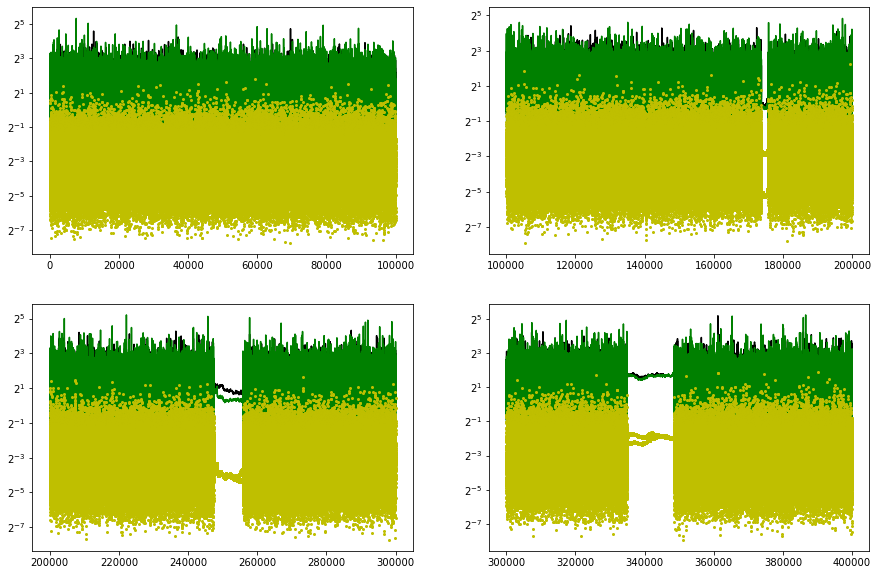

In [26]:
plt.figure(figsize = (15,10))
BASE = 2

plt.subplot(2, 2, 1)
plt.plot(1/np.sqrt(df_traces["ard_prec_1"][1:(ITER)]), "k-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_2"][1:(ITER)]), "g-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_3"][1:(ITER)]), "yo", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_4"][1:(ITER)]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 2)
plt.plot(1/np.sqrt(df_traces["ard_prec_1"][ITER:2*ITER]), "k-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_2"][ITER:2*ITER]), "g-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_3"][ITER:2*ITER]), "yo", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_4"][ITER:2*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 3)
plt.plot(1/np.sqrt(df_traces["ard_prec_1"][2*ITER:3*ITER]), "k-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_2"][2*ITER:3*ITER]), "g-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_3"][2*ITER:3*ITER]), "yo", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_4"][2*ITER:3*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 4)
plt.plot(1/np.sqrt(df_traces["ard_prec_1"][3*ITER:4*ITER]), "k-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_2"][3*ITER:4*ITER]), "g-", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_3"][3*ITER:4*ITER]), "yo", markersize=2)
plt.plot(1/np.sqrt(df_traces["ard_prec_4"][3*ITER:4*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 